### 不同產業會計文本斷詞文本對機器學習方法的影響

* 11700筆 會計文本

* 2種斷詞模式 (CKIP、JIEBA)

* NB 、 Decision Tree 、 KNN 、 SVM

* 分類出該財報是看好還是看壞

In [30]:
import pymysql
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [2]:
from ckip_transformers.nlp import CkipWordSegmenter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\Takodachi\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# jieba

import jieba

def jieba_segment(text, dict_file = 'dict.txt', stop_file = 'stop.txt'):
    # 載入詞彙字典
    jieba.load_userdict(dict_file)

    # 載入停用詞列表
    stop_words = set()
    with open(stop_file, 'r', encoding='utf-8') as f:
        for line in f:
            stop_words.add(line.strip())

    # 進行斷詞
    words = jieba.cut(text)

    # 過濾停用詞
    filtered_words = [word for word in words if word not in stop_words]

    # 將斷詞結果轉換為DataFrame
    df = pd.DataFrame({'詞語': filtered_words})

    return df

In [4]:
# ckip
import re
def ckip_segment(content,stop_file = 'stop.txt'):
    ws_driver  = CkipWordSegmenter(model="bert-base")

    # 載入停用詞列表
    stop_words = set()
    with open(stop_file, 'r', encoding='utf-8') as f:
        for line in f:
            stop_words.add(line.strip())

    try:
        words = ws_driver([content])[0]
    except ValueError:
        words = ""

    # 過濾停用詞
    filtered_words = [word for word in words if word not in stop_words]

    df = pd.DataFrame({'詞語': filtered_words})
    return df

In [5]:
# DataBase

connection = pymysql.connect(
    host='localhost',
    user='root',
    password='123456',
    database='stockdb',
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor
)

def query_by_id():
    try:
        # 使用 cursor 建立執行 SQL 的物件
        with connection.cursor() as cursor:
            # 執行 SQL 查詢
            sql = "SELECT s.industry, q.* \
                FROM stock AS s \
                JOIN quarterly_reports AS q ON s.company_code = q.company_code"
            
            cursor.execute(sql)
            result = cursor.fetchall()

            if result:
                return pd.DataFrame(result)
            else:
                print("找不到該 ID 的資料")

    except pymysql.Error as e:
        print(f"查詢發生錯誤：{e}")

    # finally:
    #     # 關閉連線
    #     connection.close()

df = query_by_id()

In [6]:
df

,industry,company_code,quarter_date,content,year
0,水泥工業,1101,01,會計師核閱報告\n\n台灣水泥股份有限公司 公鑒：\n\n前 言\n 台灣水泥股份有限公...,109
1,水泥工業,1101,01,會計師核閱報告\n\n台灣水泥股份有限公司 公鑒：\n\n前 言\n 台灣水泥股份有限公...,110
2,水泥工業,1101,01,會計師核閱報告\n\n台灣水泥股份有限公司 公鑒：\n\n前 言\n 台灣水泥股份有限公...,111
3,水泥工業,1101,02,會計師核閱報告\n\n台灣水泥股份有限公司 公鑒：\n\n前 言\n 台灣水泥股份有限公...,109
4,水泥工業,1101,02,會計師核閱報告\n\n台灣水泥股份有限公司 公鑒：\n\n前 言\n 台灣水泥股份有限公...,110
...,...,...,...,...,...
11695,鋼鐵工業,9958,03,會計師核閱報告\n\n世紀鋼鐵結構股份有限公司 公鑒：\n\n前言\n\n 世紀鋼鐵結構股...,110
11696,鋼鐵工業,9958,03,會計師核閱報告\n\n\n世紀鋼鐵結構股份有限公司 公鑒：\n\n前言\n\n 世紀鋼鐵結...,111
11697,鋼鐵工業,9958,04,會計師查核報告\n\n世紀鋼鐵結構股份有限公司 公鑒：\n\n查核意見\n\n 世紀鋼鐵結...,109
11698,鋼鐵工業,9958,04,會計師查核報告\n\n\n世紀鋼鐵結構股份有限公司 公鑒：\n\n查核意見\n\n 世紀鋼...,110


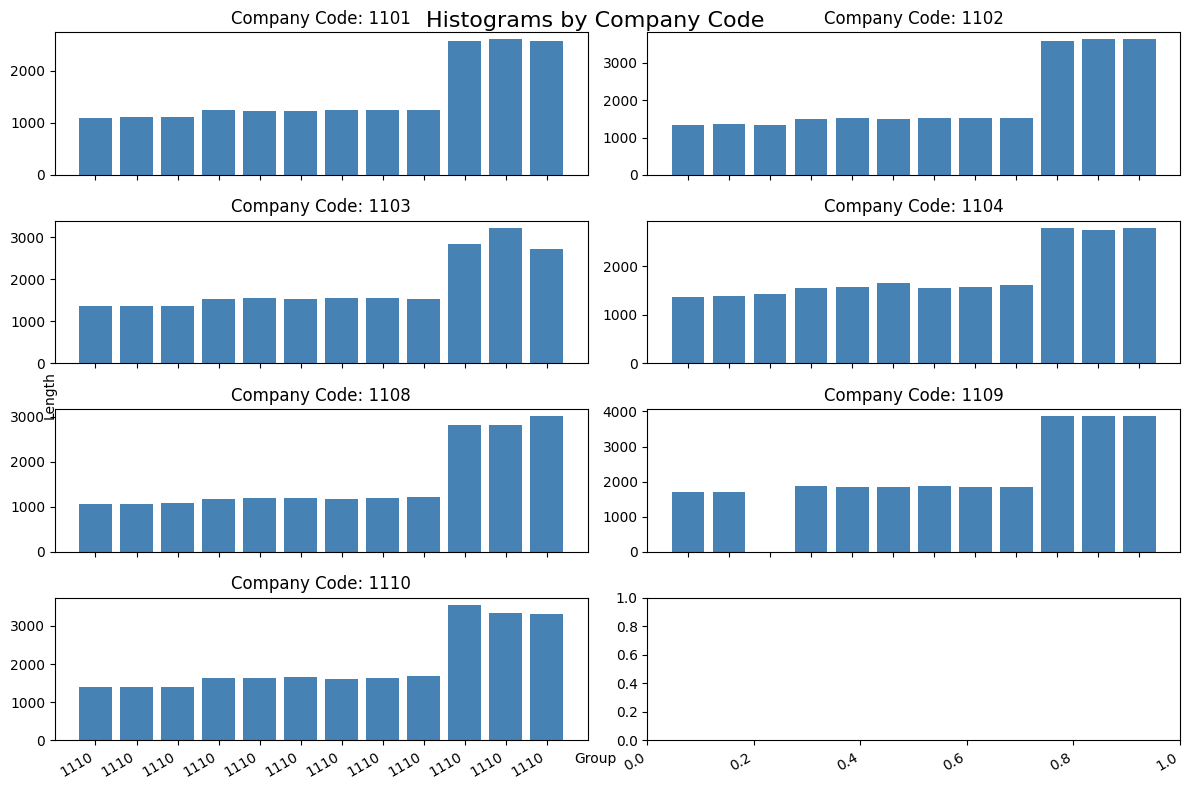

In [7]:
import warnings

def plot_histogram(df, industry):
    warnings.filterwarnings("ignore")

    cement = df[df['industry'] == industry]
    content = cement['content']
    word_count = [len(text) for text in content]
    code = cement['company_code']
    data = pd.DataFrame({
        'code': code,
        'length': word_count
    })

    # 根據 company_code 分類資料
    grouped_data = data.groupby('code')

    # 計算子圖的行數和列數
    num_subplots = len(grouped_data)
    num_rows = num_subplots // 2 + num_subplots % 2
    num_cols = 2

    # 設置繪圖區域和圖表大小
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))


    # 繪製每個子圖
    for (code, data), ax in zip(grouped_data, axs.flat):
        ax.bar(data.index, data['length'], color='steelblue')
        ax.set_xticks(data.index)
        ax.set_xticklabels(data['code'])
        ax.tick_params(axis='x', rotation=45)
        ax.set_title(f"Company Code: {code}")

    # 自適應調整 X 軸刻度標籤
    fig.autofmt_xdate()

    # 調整子圖間的間距
    plt.tight_layout()

    # 添加標題和共用的軸標籤
    fig.suptitle("Histograms by Company Code", fontsize=16)
    fig.text(0.5, 0.04, "Group", ha='center')
    fig.text(0.04, 0.5, "Length", va='center', rotation='vertical')

    # 顯示圖表
    plt.show()

# 呼叫函數並傳遞資料框和行業參數
plot_histogram(df, "水泥工業")


In [8]:
import pandas as pd
import random

def random_sample(df, n):
    industries = df['industry'].unique()
    sampled_industries = random.sample(list(industries), n)
    sampled_data = pd.DataFrame()

    for industry in sampled_industries:
        industry_data = df[df['industry'] == industry].sample(1)
        sampled_data = pd.concat([sampled_data, industry_data])
    sampled_data['content'] = sampled_data['content'].astype(str)

    return sampled_data

# 呼叫函數並傳遞資料框和欲抽取的資料組數
sampled_data = random_sample(df, 10)

In [9]:
def clear(content):
    result_str = ''
    for word in content:
        if word == '\u3000' or word == '\n':
            continue
        result_str += word
    
    # 移除標點符號
    result_str = re.sub(r'[^\w\s]', '', result_str)
    # 移除空格
    result_str = re.sub(r'\s+', '', result_str)

    return result_str

In [10]:
# 清理、去除
random_data = list(sampled_data['content'])
for r in range(len(random_data)):
    random_data[r] = clear(random_data[r])

random_data[0]

'會計師查核報告幸福水泥股份有限公司公鑒查核意見幸福水泥股份有限公司及其子公司幸福水泥集團民國110年及109年12月31日之合併資產負債表暨民國110年及109年1月1日至12月31日之合併綜合損益表合併權益變動表合併現金流量表以及合併財務報告附註包括重大會計政策彙總業經本會計師查核竣事依本會計師之意見上開合併財務報告在所有重大方面係依照證券發行人財務報告編製準則及經金融監督管理委員會認可並發布生效之國際財務報導準則國際會計準則解釋及解釋公告編製足以允當表達幸福水泥集團民國110年及109年12月31日之合併財務狀況暨民國110年及109年1月1日至12月31日之合併財務績效及合併現金流量查核意見之基礎本會計師係依照會計師查核簽證財務報表規則及一般公認審計準則執行查核工作本會計師於該等準則下之責任將於會計師查核合併財務報告之責任段進一步說明本會計師所隸屬事務所受獨立性規範之人員已依會計師職業道德規範與幸福水泥集團保持超然獨立並履行該規範之其他責任本會計師相信已取得足夠及適切之查核證據以作為表示查核意見之基礎關鍵查核事項關鍵查核事項係指依本會計師之專業判斷對幸福水泥集團民國110年度合併財務報告之查核最為重要之事項該等事項已於查核合併財務報告整體及形成查核意見之過程中予以因應本會計師並不對該等事項單獨表示意見茲對幸福水泥集團民國110年度合併財務報告之關鍵查核事項敘明如下來自重點客戶銷貨收入真實發生幸福水泥集團之銷貨收入主要來自水泥石材及其他水泥附屬製品等之銷售幸福水泥集團民國110年度合併銷貨收入淨額相較民國109年度減少惟其中民國110年度來自合併銷貨收入淨額相較民國109年度增加之主要客戶以下稱重點客戶占合併銷貨收入淨額之20對合併財務報表影響係屬重大因此本會計師將該重點客戶之銷貨收入是否確實發生列為本年度之關鍵查核事項有關收入認列會計政策請參閱合併財務報告附註四十一收入相關說明請參閱合併財務報告附註二四一本會計師對於上述關鍵查核事項已執行主要查核程序如下1了解重點客戶銷貨交易相關之內部控制制度並評估其設計與執行之有效性2取得重點客戶全年度收入之銷貨交易彙總明細調節並確認其相關交易明細之完整性並自明細中選取樣本核至交易之相關憑證以驗證其收入認列之真實性3取得期後之銷貨明細帳檢視有無發生重大銷貨退回及折讓以確認收入認列有無重大異常其他事項幸福水泥股份有限公司業已

In [11]:
# jieba
jieba_array = []
for i in range(10):
    text = random_data[i]
    jieba_array.append(jieba_segment(text))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TAKODA~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.422 seconds.
Prefix dict has been built successfully.


In [12]:
# CKIP
ckip_array = []
for i in range(10):
    text = random_data[i]
    ckip_array.append(ckip_segment(text))


Inference: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


## 詞性標註任務

* ckip_array 、 jieba_array

* 名詞 (Noun)

* 代詞 (Pronoun)

* 動詞 (Verb)

* 形容詞 (Adjective)

* 副詞 (Adverb)

* 介詞 (Preposition)

* 連詞 (Conjunction)

* 助詞 (Particle)

* 量詞 (Measure Word)

* 虛詞 (Function Word)

* 叹詞 (Interjection)

* 時詞 (Temporal Word)

In [13]:
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

ws_driver = CkipWordSegmenter(model="albert-base", device=0)
pos_driver = CkipPosTagger(model="albert-base", device=0)
ner_driver = CkipNerChunker(model="albert-base", device=0)


Inference: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


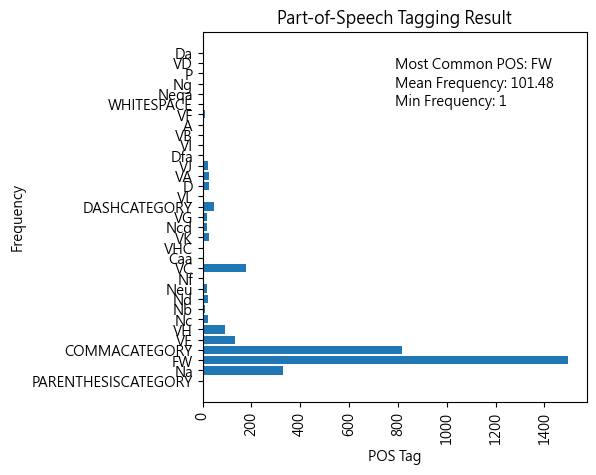

In [52]:
def plot_pos_tags(ckip_array):
    # 取得要進行詞性標註的句子
    for i in range(10):
        sentence = str(list(ckip_array[i]['詞語']))

        # 進行斷詞和詞性標註
        word_sentence_list = ws_driver([sentence])
        pos_sentence_list = pos_driver(word_sentence_list)

        # 整理詞性標註結果
        pos_tags = [pos for pos_sentence in pos_sentence_list for pos in pos_sentence]

        # 計算詞性頻率
        pos_freq = Counter(pos_tags)
        most_common_pos, most_common_freq = pos_freq.most_common(1)[0]
        mean_pos = sum(pos_freq.values()) / len(pos_freq)
        min_pos = min(pos_freq.values())

        # 取得詞性標籤和頻率資料
        labels, values = zip(*pos_freq.items())


        # 繪製長條圖
        plt.barh(labels, values)

        # 添加標題和軸標籤
        plt.title("Part-of-Speech Tagging Result")
        plt.xlabel("POS Tag")
        plt.ylabel("Frequency")

        # 設置X軸標籤旋轉角度為45度
        plt.xticks(rotation=90)

        # 調整 Y 軸間距
        plt.subplots_adjust(left=0.3)

        # 顯示最多出現頻率、平均頻率和最小頻率
        plt.text(0.5, 0.9, f"Most Common POS: {most_common_pos}", transform=plt.gca().transAxes)
        plt.text(0.5, 0.85, f"Mean Frequency: {mean_pos:.2f}", transform=plt.gca().transAxes)
        plt.text(0.5, 0.8, f"Min Frequency: {min_pos}", transform=plt.gca().transAxes)

        # 顯示圖表
        plt.show()

In [ ]:
plot_pos_tags(ckip_array)

Inference: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


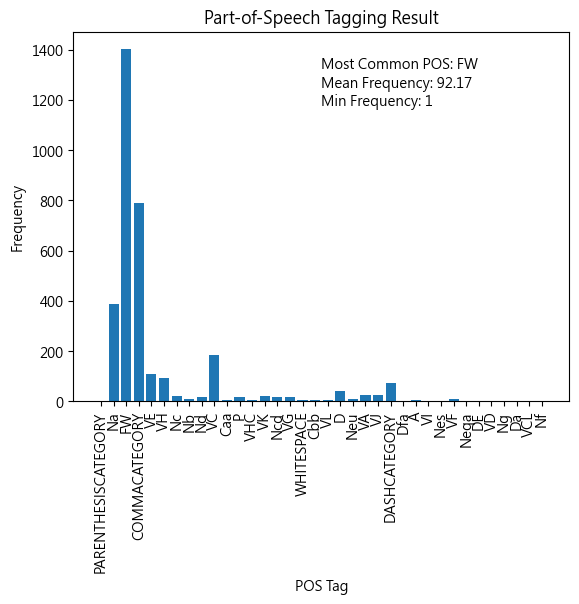

In [44]:
plot_pos_tags(jieba_array)